In [1]:
import os 
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

from src import params
import ast
from pathlib import Path
import warnings
import hdbscan
warnings.filterwarnings('ignore')
final_data_path = Path.cwd().parents[1]/'data/final_data'

# prepare data


### 1.1a read diseases data from fo+cancer

In [8]:
# read the fo+cancer data 
selected_cols = ['diseases_within_window_phecode','chapter_within_window_phecode']
data_file = "UKB_wave_0_diseases_first_occurrence_and_cancer.pkl"
df_phe_selected = pd.read_pickle(f'{str(params.final_data_path).replace("src/modelling/","")}/{data_file}')

type = 'fo+cancer' # 'HES' 
year_type = ['pre_recruit', '5_years', '10_years'][0] # pre_recruit 5_years 10_years


In [14]:
# select which years and mark chapters 

if type == 'fo+cancer':
    if year_type == '5_years':
        cols = ['phecode_pre_recruit','phecode_0_5']
        df_phe_selected['diseases_within_window_phecode'] = df_phe_selected[cols].apply(lambda x: list(set(x[0] + x[1])), axis=1)
    
    elif year_type == 'pre_recruit':
        cols = ['phecode_pre_recruit']
        df_phe_selected['diseases_within_window_phecode'] = df_phe_selected['phecode_pre_recruit']
        
    elif year_type == '10_years':
        cols = ['phecode_pre_recruit','phecode_0_5','phecode_5_10']
    
        df_phe_selected['diseases_within_window_phecode'] = df_phe_selected[cols].apply(lambda x: list(set(x[0] + x[1]+x[2])), axis=1)
        
    #  mark chapters 
    df_phe_db = pd.read_csv('/Users/valler/Python/OX_Thesis/Chapter_2_Disease_Clustering/Data/downloaded_data/ICD_10/phecode_definitions1.2.csv')
    df_phe_selected["chapter_within_window_phecode"] = [[df_phe_db.loc[df_phe_db['phecode']==disease,'category_number'].values[0] for disease in x] if str(x) not in params.nan_str else None for x in df_phe_selected["diseases_within_window_phecode"]]
    del df_phe_db
    
    for col in selected_cols:
        df_phe_selected[col] = [x if str(x)!='[]' else None for x in df_phe_selected[col]]
elif type == 'HES':
    # or read the hospital data
    record_column = params.disease_record_column
    selected_cols = ['diseases_within_window_phecode_selected_chronic_first_occ','diseases_within_window_phecode_selected_category_chronic_first_occ']
    
    
    df_single_record = pd.read_csv(Path.cwd().parents[1]/f'data/intermediate_files/{record_column}_complete.csv')
    level = 'chronic'
    year_type = ''
    cols = [x for x in df_single_record.columns if 'phe' in x]
    # with gender and age? yes as they are part of the physical conditions
    df_phe_selected = df_single_record[['eid','21022','31']+selected_cols].copy()
    for column in selected_cols:
        df_phe_selected[column] = [ast.literal_eval(x) if str(x) not in params.nan_str else None for x in df_phe_selected[column]]

### 1.2 combine diseases with social data 

In [15]:
# 2 add more columns to describe the diseases within the window
nan_str = params.nan_str
df_phe_selected['diseases_count'] = [len(x) if str(x) not in nan_str else 0 for x in df_phe_selected[selected_cols[0]]]


# 0.3 flatten the selected_cols
phe_unique = df_phe_selected[selected_cols[0]].explode().explode().dropna().unique().tolist()
cat_unique = df_phe_selected[selected_cols[1]].explode().explode().dropna().unique().tolist()

# phe code level
df_phe_selected['phe_count'] = [Counter(x) if str(x) not in nan_str else None for x in df_phe_selected[selected_cols[0]]]
df_phe_selected['cat_count'] = [Counter(x) if str(x) not in nan_str else None for x in df_phe_selected[selected_cols[1]]]

# Create a new DataFrame for the new columns

for columns,counter_colname,colname_sart in [[cat_unique,'cat_count','c_'],[phe_unique,'phe_count','d_']]:
    new_columns = {
        f'{colname_sart}{column}': [
            None if (str(x) == 'None') else x[column] if (column in x.keys()) else None
            for x in df_phe_selected[counter_colname]
        ]
        for column in columns  # Assuming target_columns is a list of columns you want to process
    }
    
    new_columns_df = pd.DataFrame(new_columns)
    df_phe_selected = pd.concat([df_phe_selected, new_columns_df], axis=1)

In [16]:

#df_phe_selected.drop(columns=['diseases_within_window_phecode','chapter_within_window_phecode', 'phe_count'],inplace=True)
df_phe_selected.fillna(0, inplace=True)

# combine with the social data
df = pd.read_pickle(final_data_path / 'UKB_wave_0_final_standardised.pkl')

for col in ['21022','31']:
    if col not in df_phe_selected.columns.tolist():
        df_phe_selected = df_phe_selected.merge(df[['eid',col]],on='eid',how='left')

# standardise the columns
for column in ['21022','diseases_count']:
    df_phe_selected[column] = (df_phe_selected[column]-df_phe_selected[column].mean())/df_phe_selected[column].std()

df = df.merge(df_phe_selected.drop(columns=['21022','31']), on='eid', how='left')


In [17]:
# delete death samples from the data fitting into the algorithms
if year_type not in ['','pre_recruit']:
    
     # read the recruitment date 
    if '53' not in df_phe_selected.columns.tolist():
        df_non_standard = pd.read_pickle(f'{final_data_path}/UKB_wave_0_final_non_standardised.pkl')
        df_phe_selected = df_phe_selected.merge(df_non_standard[['eid','53']], on='eid', how='left')
        del df_non_standard
    
    # read death date 
    if 'death_date' not in df_phe_selected.columns.tolist():
        df_death = pd.read_pickle(final_data_path / 'death_data.pkl')
        df_phe_selected = df_phe_selected.merge(df_death[['eid','death_date']],on='eid',how='left')
        del df_death
         
    df_phe_selected['death_diff'] =df_phe_selected['death_date']-pd.to_datetime(df_phe_selected['53'])
    df_phe_selected[f'death{year_type}'] = [1 if x.days<=365*int(year_type.split('_')[0]) else 0 for x in df_phe_selected['death_diff']] 
    df = df.merge(df_phe_selected[['eid',f'death{year_type}']],on='eid',how='left') 
     
    df_phe_selected_death_samples = df_phe_selected[df_phe_selected[f'death{year_type}']==1].copy()
    df_phe_selected = df_phe_selected[df_phe_selected[f'death{year_type}']==0].copy()


In [18]:
df.to_pickle(params.intermediate_path.parents[3]/'Data/intermediate_files/data_right_before_umap' / f'UKB_{year_type}_df.pkl')

# UMAP


In [19]:
hyp =  {'umap':{'pre_recruit': {'n_components': 3, 'n_neighbors': 20, 'min_dist': 0.2},
                '5_years': {'n_components': 3, 'n_neighbors': 50, 'min_dist': 0.2},
               '10_years': {'n_components': 3, 'n_neighbors': 20, 'min_dist': 0.2}}}

# hyper-parameters
n_components = hyp['umap'][year_type]['n_components']
n_neighbors = hyp['umap'][year_type]['n_neighbors']
min_dist = hyp['umap'][year_type]['min_dist']


print(f'{year_type} UMAP hyper-parameters: n_components={n_components}, n_neighbors={n_neighbors}, min_dist={min_dist}')

pre_recruit UMAP hyper-parameters: n_components=3, n_neighbors=20, min_dist=0.2


A higher min_dist ensures that points are not overly compacted in the embedding, which may help to clarify cluster boundaries.

In [20]:
#Initialize UMAP
import umap
from joblib import parallel_backend

# Set number of threads to max available cores
with parallel_backend('loky', n_jobs=-1):  # -1 will use all available cores
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    if type == 'fo+cancer':
        temp = df_phe_selected[[x for x in df_phe_selected.columns if (x.startswith('c_') or (x.startswith('d_')))]+['diseases_count']]
        embedding = reducer.fit_transform(temp)

df_embed = pd.concat([df_phe_selected[['eid']].reset_index(drop=True),pd.DataFrame(embedding)],axis=1)
#df_embed.to_csv(Path.cwd().parents[1]/f'result/umap_only_diseases_{type}_{year_type}_{n_components}_{n_neighbors}_{min_dist}.csv',index=False)
df_embed.to_csv(Path.cwd().parents[1]/f'result/umap/umap_only_diseases_{type}_{year_type}_{n_components}_{n_neighbors}_{min_dist}.csv',index=False)

df_embed = pd.read_csv(Path.cwd().parents[1]/f'result/umap_only_diseases_{type}_{year_type}_{n_components}_{n_neighbors}_{min_dist}.csv')
df_embed.rename(columns={"0":0,"1":1},inplace=True)

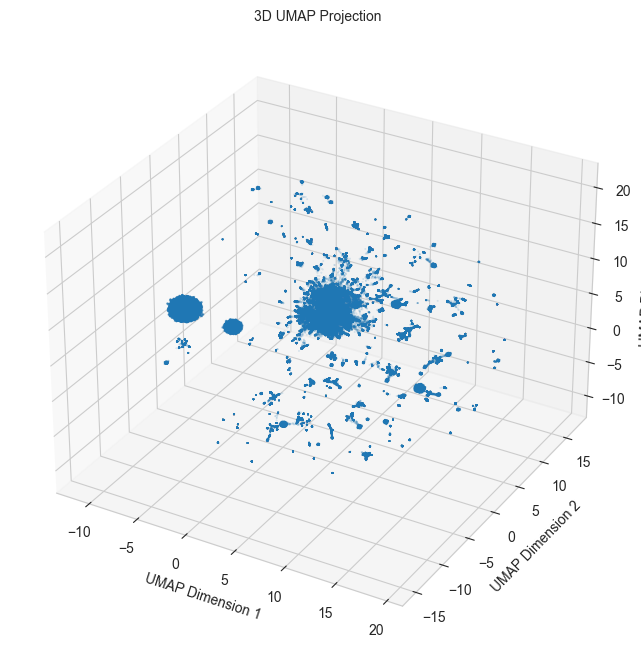

In [21]:
if n_components==3:
    from mpl_toolkits.mplot3d import Axes3D
    
    # Adjust for 3D visualization
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot in 3D
    ax.scatter(df_embed[0], df_embed[1], df_embed[2], s=0.1, alpha=0.2)
    
    # Set titles and labels
    ax.set_title('3D UMAP Projection', fontsize=10)
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_zlabel('UMAP Dimension 3')
    
else:
    
    plt.figure(figsize=(12, 8))
    plt.scatter(df_embed[0], df_embed[1], s=0.0001, alpha=0.2)
    plt.title('UMAP projection', fontsize=10)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    


In [22]:
for col in df_embed.columns:
    if col !='eid':
        print(f'{col} mean = {df_embed[col].mean()} std = {df_embed[col].std()}')

0 mean = 1.0119017362594604 std = 8.245160102844238
1 mean = 0.40574556589126587 std = 6.1105732917785645
2 mean = 5.119738578796387 std = 6.054715156555176


5_years
 
3_50_0.2
0 7.158688068389893 10.230504989624023
1 4.564391613006592 7.7604851722717285
2 4.928802967071533 7.277823448181152

3_50_0.1
0 mean = 8.683643341064453 std = 10.693658828735352
1 mean = 1.5758066177368164 std = 7.175358772277832
2 mean = 9.2239408493042 std = 6.464634895324707


10 years 

3_50_0.1
0 mean = 9.443999290466309 std = 7.035427093505859
1 mean = 7.329482555389404 std = 7.168684482574463
2 mean = 5.28171968460083 std = 6.299867630004883

3_50_0.2

0 mean = 8.506775856018066 std = 7.916617393493652
1 mean = 5.733652114868164 std = 5.463183403015137
2 mean = 3.550140380859375 std = 6.565299034118652


# HDBSCAN

# codes to execute if we skip the umap section
n_components = 3
n_neighbors =20
min_dist = 0.1
year_type = '5_years'



In [66]:
import numpy as np 
def plot_hdbscan_in_umap_space(df_embed, type, year_type, n_components, n_neighbors, min_dist, min_cluster_size, min_samples,metric,disease_count_contrl,save_contrl=True):
    labels = df_embed['cluster']
    if n_components==2:
        plt.scatter(df_embed[0], df_embed[1], c=labels, s=0.001, alpha=1)
        plt.colorbar(label='Cluster')
        plt.title(f'UMAP + HDBSCAN Clustering {year_type}', fontsize=15)
        plt.show()
    elif n_components==3:
        unique_labels = np.unique(labels)  # Get unique labels
    
        # Define colors for each label (Matplotlib assigns colors automatically)
        colors = plt.cm.tab10(unique_labels % 10)  # Using a colormap
        
        # Create a scatter plot
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot each cluster with its unique color
        for label, color in zip(unique_labels, colors):
            mask = labels == label
            ax.scatter(df_embed[0][mask], df_embed[1][mask], df_embed[2][mask], 
                       c=[color], label=f'Cluster {label} {len(df_embed[mask])}', s=0.001, alpha=1)
        
        # Add a legend
        ax.legend(title="Clusters", loc='upper right', fontsize=10)
        
        # Set plot titles and labels
        ax.set_title(f'{year_type} {min_cluster_size} {min_samples}', fontsize=15)
        ax.set_xlabel('UMAP Dimension 1')
        ax.set_ylabel('UMAP Dimension 2')
        ax.set_zlabel('UMAP Dimension 3')
        ax.grid(True,alpha=0)
    if save_contrl:
        save_path = Path.cwd().parents[1] / f'plot/umap+hdbscan/heatmap_{type}_{year_type}_{n_components}_{n_neighbors}_{min_dist}_{min_cluster_size}_{min_samples}_{metric}{"_no_diseases_count" if not disease_count_contrl else ""}.png'
        plt.savefig(save_path)
    

In [24]:
import hdbscan
hyp['hdbscan']= {'pre_recruit': {'min_cluster_size': 25000, 'min_samples': 20,'disease_count_contrl':False},
               '5_years': {'min_cluster_size': 25000, 'min_samples': 100,'disease_count_contrl':False},
               '10_years': {'min_cluster_size': 20000, 'min_samples': 50,'disease_count_contrl':False}} 


min_cluster_size = hyp['hdbscan'][year_type]['min_cluster_size']
min_samples = hyp['hdbscan'][year_type]['min_samples']
disease_count_contrl = hyp['hdbscan'][year_type]['disease_count_contrl']
print(f'{year_type} HDBSCAN hyper-parameters: min_cluster_size={min_cluster_size}, min_samples={min_samples}')

pre_recruit HDBSCAN hyper-parameters: min_cluster_size=25000, min_samples=20


In [25]:
f'result/umap/umap_only_diseases_{type}_{year_type}_{n_components}_{n_neighbors}_{min_dist}.csv'

'result/umap/umap_only_diseases_fo+cancer_pre_recruit_3_20_0.2.csv'

##  Functions to fit the HDBSCAN (if the file is not available)

In [89]:
year_type='5_years'

In [90]:
# selected hyper-parameters
hyp =  {'umap':{'pre_recruit': {'n_components': 3, 'n_neighbors': 20, 'min_dist': 0.2},
                '5_years': {'n_components': 3, 'n_neighbors': 50, 'min_dist': 0.2},
               '10_years': {'n_components': 3, 'n_neighbors': 20, 'min_dist': 0.2}}}

hyp['hdbscan']= {'pre_recruit': {'min_cluster_size': 25000, 'min_samples': 100,'disease_count_contrl':False},
               '5_years': {'min_cluster_size': 20000, 'min_samples': 150,'disease_count_contrl':False},
               '10_years': {'min_cluster_size': 20000, 'min_samples': 20,'disease_count_contrl':False}} # disease_count_contrl tbc 


n_components = hyp['umap'][year_type]['n_components']
n_neighbors = hyp['umap'][year_type]['n_neighbors']
min_dist = hyp['umap'][year_type]['min_dist']
min_cluster_size = hyp['hdbscan'][year_type]['min_cluster_size']
min_samples = hyp['hdbscan'][year_type]['min_samples']
disease_count_contrl = hyp['hdbscan'][year_type]['disease_count_contrl']


print(f'{year_type} UMAP hyper-parameters: n_components={n_components}, n_neighbors={n_neighbors}, min_dist={min_dist}')
print(f'{year_type} HDBSCAN hyper-parameters: min_cluster_size={min_cluster_size}, min_samples={min_samples}, disease_count_contrl={disease_count_contrl}')


5_years UMAP hyper-parameters: n_components=3, n_neighbors=50, min_dist=0.2
5_years HDBSCAN hyper-parameters: min_cluster_size=20000, min_samples=150, disease_count_contrl=False


In [91]:
from sklearn.metrics.pairwise import cosine_distances 
import hdbscan
embed_filepath = Path.cwd().parents[1]/f'result/hdbscan/umap_hdbscan_only_diseases_{type}_{year_type}_{n_components}_{n_neighbors}_euclidean_{min_dist}_{min_cluster_size}_{min_samples}{"_no_diseases_count" if not disease_count_contrl else ""}.csv'


if os.path.isfile(embed_filepath):
    print('embed file found, we will read the file')
    df_embed = pd.read_csv(embed_filepath)
    df_embed.rename(columns={"0":0,"1":1,"2":2},inplace=True)
    df = pd.read_pickle(params.intermediate_path.parents[3]/'Data/intermediate_files/data_right_before_umap' / f'UKB_{year_type}_df.pkl')
    df = pd.merge(df,df_embed[['eid','cluster']],on='eid',how='left')
    
    if year_type not in ['','pre_recruit']:
        df['cluster'] = [x if pd.notnull(x) else -2 if y==1 else None for x,y in zip(df['cluster'],df[f'death{year_type}'])]
        
    
else:
    print('file not found, we will fit the HDBSCAN on the UMAP embeddings, with the hyper-parameters')
    embed_path = Path.cwd().parents[1]/f'result/umap/umap_only_diseases_{type}_{year_type}_{n_components}_{n_neighbors}_{min_dist}.csv'
    df = pd.read_pickle(params.intermediate_path.parents[3]/'Data/intermediate_files/data_right_before_umap' / f'UKB_{year_type}_df.pkl')
    print(embed_path)
    df_embed = pd.read_csv(embed_path)
    
    df_embed.rename(columns={"0":0,"1":1,"2":2},inplace=True)
    
    # combine with the social data
    df_phe_selected['diseases_count'] = [len(x) if str(x) not in params.nan_str+['[]'] else 0 for x in df_phe_selected['phecode_pre_recruit']]
    # standardise the columns
    for column in ['diseases_count']:
        df_phe_selected[column] = (df_phe_selected[column]-df_phe_selected[column].mean())/df_phe_selected[column].std()
    if 'diseases_count' not in df_embed.columns.tolist():
        df_embed = df_embed.merge(df_phe_selected[['eid','diseases_count']],on='eid',how='left')
        
        
    # Fit HDBSCAN on the UMAP embeddings
    metric = 'euclidean'
    if metric!='euclidean':
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,metric ='precomputed')
        
        if n_components==2:
            distance_matrix = cosine_distances(df_embed[[0, 1,'diseases_count']])
        elif n_components==3:
            distance_matrix = cosine_distances(df_embed[[0, 1,2,'diseases_count']])
        labels = clusterer.fit_predict(distance_matrix)
    else: 
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        if n_components==2:
            labels = clusterer.fit_predict(df_embed[[0, 1,'diseases_count']])
        elif n_components==3:
            labels = clusterer.fit_predict(df_embed[[0, 1,2,'diseases_count']])
            
    
    df_embed['cluster'] = labels
    print(f'min_cluster_size={min_cluster_size}, min_samples={min_samples}')
    print(df_embed.value_counts('cluster'))
    
    
    df_embed['cluster'] = labels
    df_embed.value_counts('cluster')
    df_embed.to_csv(embed_filepath,index=False)
    plot_hdbscan_in_umap_space(df_embed, type, year_type, n_components, n_neighbors, min_dist, min_cluster_size, min_samples,metric,disease_count_contrl)
    
       
    if 'cluster' in df.columns:
        df.drop(columns='cluster',inplace=True)
    df = df.merge(df_embed[['eid','cluster']], on='eid', how='left')
    
    if year_type not in ['','pre_recruit']:
        df['cluster'] = [x if pd.notnull(x) else -2 if y==1 else None for x,y in zip(df['cluster'],df[f'death{year_type}'])]

embed file found, we will read the file


## grid searching HDBSCAN hyper parameters on the UMAP embeddings


from sklearn.metrics.pairwise import cosine_distances
disease_count_contrl = False 
metric = 'euclidean'
for min_cluster_size in [10000,15000, 20000 ,25000]:
    for min_samples in [20,50,100,150]:
        if not os.path.isfile(Path.cwd().parents[1]/f'result/hdbscan/umap_hdbscan_only_diseases_{type}_{year_type}_{n_components}_{n_neighbors}_{metric}_{min_dist}_{min_cluster_size}_{min_samples}{"_no_diseases_count" if not disease_count_contrl else ""}.csv'):
    
            if metric!='euclidean':
                clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples,metric ='precomputed')
                
                if n_components==2:
                    if disease_count_contrl:
                        distance_matrix = cosine_distances(df_embed[[0, 1,'diseases_count']])
                    else:
                        distance_matrix = cosine_distances(df_embed[[0, 1]])
                elif n_components==3:
                    if disease_count_contrl:
                        distance_matrix = cosine_distances(df_embed[[0, 1,2,'diseases_count']])
                    else:
                        distance_matrix = cosine_distances(df_embed[[0, 1,2]])  
                labels = clusterer.fit_predict(distance_matrix)
            else: 
                clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
                if n_components==2:
                    if disease_count_contrl:
                        labels = clusterer.fit_predict(df_embed[[0, 1,'diseases_count']])
                    else:
                        labels = clusterer.fit_predict(df_embed[[0, 1]])
                elif n_components==3:
                    if disease_count_contrl:
                        labels = clusterer.fit_predict(df_embed[[0, 1, 2,'diseases_count']]) 
                    else:
                        labels = clusterer.fit_predict(df_embed[[0, 1,2]])
            
            df_embed['cluster'] = labels
            print(f'min_cluster_size={min_cluster_size}, min_samples={min_samples}')
            print(df_embed.value_counts('cluster'))
            
            
            df_embed['cluster'] = labels
            df_embed.value_counts('cluster')
            df_embed.to_csv(Path.cwd().parents[1]/f'result/hdbscan/umap_hdbscan_only_diseases_{type}_{year_type}_{n_components}_{n_neighbors}_{metric}_{min_dist}_{min_cluster_size}_{min_samples}{"_no_diseases_count" if not disease_count_contrl else ""}.csv',index=False)
            plot_hdbscan_in_umap_space(df_embed, type, year_type, n_components, n_neighbors, min_dist, min_cluster_size, min_samples,metric,disease_count_contrl)
        else:
            print(f'file found for the hyper-parameters min_cluster_size={min_cluster_size}, min_samples={min_samples}') 

In [92]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import ast

def plot_cluster_mean_heatmap_with_scaling(df, df_single_record, final_data_path, key_vars, non_replace, age_column, params, n_components, n_neighbors, min_dist, min_cluster_size, min_samples):
    # Load the non-standardized dataframe
    df_non_standard = pd.read_pickle(final_data_path / 'UKB_wave_0_final_non_standardised.pkl')
    df_non_standard[f'10722'].replace({3:1,2:1, list(df_non_standard['10722'].unique())[1]:1, 4:2,1:2,5:3},inplace=True)
    # Add the 'diseases_count' column from df_single_record to df_non_standard
    #df_single_record['diseases_count'] = [len(ast.literal_eval(str(x))) if str(x) not in params.nan_str else 0 for x in df_single_record[selected_cols[1]]]
    
    df['diseases_count'] = [len(x) if str(x) not in params.nan_str+['0'] else  0 for x in df[selected_cols[0]]]
    
    df_non_standard = df_non_standard.merge(df[['eid', 'diseases_count']], on='eid', how='left')
    df_non_standard.dropna(subset=['diseases_count'], inplace=True)
     
    # Add cluster labels to the non-standardized DataFrame
    df_non_standard['cluster'] = df['cluster']

    # Group by cluster and get the mean of key variables
    cluster_means = df.groupby('cluster')[list(key_vars.keys())].mean()

    # Exclude the columns in non_replace from scaling
    columns_to_scale = list(set(key_vars.keys()) - set(non_replace))

    # Scale the relevant columns in df between 0 and 1
    scaler = MinMaxScaler()
    cluster_means[columns_to_scale] = scaler.fit_transform(cluster_means[columns_to_scale])

    # Get the mean for non-standardized data, excluding columns in non_replace
    cluster_means_non_standard = df_non_standard.groupby('cluster')[columns_to_scale].mean()

    # Compute the mean age for each cluster and sort clusters by age
    mean_age_by_cluster = df.groupby('cluster')[age_column].mean()
    sorted_clusters = mean_age_by_cluster.sort_values().index

    # Reorder cluster_means and cluster_means_non_standard by sorted_clusters (based on mean age)
    cluster_means_sorted = cluster_means.loc[sorted_clusters]
    cluster_means_non_standard_sorted = cluster_means_non_standard.loc[sorted_clusters]

    # Prepare annotations: for columns in non_replace, use values from df; for others, use values from df_non_standard
    annotations = cluster_means_sorted.copy()  # Start with df annotations
    for column in key_vars.keys():
        if column not in non_replace:
            annotations[column] = round(cluster_means_non_standard_sorted[column], 2)
        else:
            annotations[column] = round(annotations[column], 2)
    annotations = annotations.T

    # Create the heatmap (rotated axes) based on df values (colors)
    plt.figure(figsize=(10, 10))
    ax = sns.heatmap(cluster_means_sorted.T, annot=annotations.values, fmt='', cmap='Reds', linewidths=0.5, cbar=False)

    # Rotate axes: clusters on the x-axis, key variables on the y-axis
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    ax.set_yticklabels(list(key_vars.values()), rotation=0)

    diseases_count_index = list(key_vars.keys()).index('diseases_count')

    # Add the text annotations and the horizontal lines based on the diseases_count_index
    #ax.text(-5, diseases_count_index - 2, 'Social Factors', rotation=90, fontsize=12)
    ax.hlines(diseases_count_index, 0, len(sorted_clusters)+3, colors='grey', linestyles='dashed')
    #ax.text(-5, len(key_vars) - 2.5, 'Chronic Diseases', rotation=90, fontsize=12)


    plt.xlabel('Clusters (sorted by mean age)')


    # Show the plot
    plt.tight_layout()
    save_path = Path.cwd().parents[1] / f'plot/cluster_social_factors/cluster_heatmap_{type}_{year_type}_{n_components}_{n_neighbors}_{min_dist}_{min_cluster_size}_{min_samples}.pdf'
    plt.savefig(save_path)
    plt.show()


df['cluster'].replace({5:7,6:5},inplace=True)
df['cluster'].replace({7:6},inplace=True)

In [93]:
# key vars
key_vars = {'21022': "age",
            '31': "gender",
            "10722":"education",
            "738":"household income",
            "20277":"Job Code",
            "22189":"Index of Multiple Deprivation",

            "3526": "Mother's age at death",
            "1807": "Father's age at death",
            "120": "Birth weight known",
            '1787': 'Maternal smoking around birth',

             '399': 'Number of incorrect matches in round',
            "2020":"Loneliness, isolation",
            "2050": "Frequency of depressed mood in last 2 weeks",
            "1980": "Worrier / anxious feelings",
             "2090": "Seen doctor (GP) for nerves, anxiety, tension or depression",
            "2100": "Seen a psychiatrist for nerves, anxiety, tension or depression",


            "1200":"Sleeplessness / insomnia",
            '1160':'Sleep Duration',
            "1239":"Current tobacco smoking",
            "20160": "Ever smoked",
            "20116":"Smoking status",
            "1269": "Exposure to tobacco smoke at home",
            "1259": "Smoking/smokers in household",
            "20117":"Alcohol Drinker",
            "1558": "Alcohol intake frequency",


             "864": "Number of days/week walked 10+ minutes",
             "22036": "At or above moderate/vigorous/walking recommendation",
            "22035": "At or above moderate/vigorous recommendation",
             # "1100": "Drive faster than motorway speed limit",

             #"1359": "Poultry intake",
             #"1389": "Pork intake",
            #"1339": "Non-oily fish intake",
            "1538": "Major dietary changes in the last 5 years",

            "2335": "Chest pain or discomfort",
            "2296": "Falls in the last year",
            "23104":"Body mass index (BMI)",

            "2178":"Overall health rating",

            'diseases_count':'Diseases count'}


phe_cate_dict_rev = {v:k for k,v in params.phe_cate_dict.items()}
phe_cate_dict_rev[18] = 'injuries & poisonings'
for x in [x for x in df.columns if x.startswith('c_')]:
    key_vars[x] = phe_cate_dict_rev[int(x.replace('c_',''))]


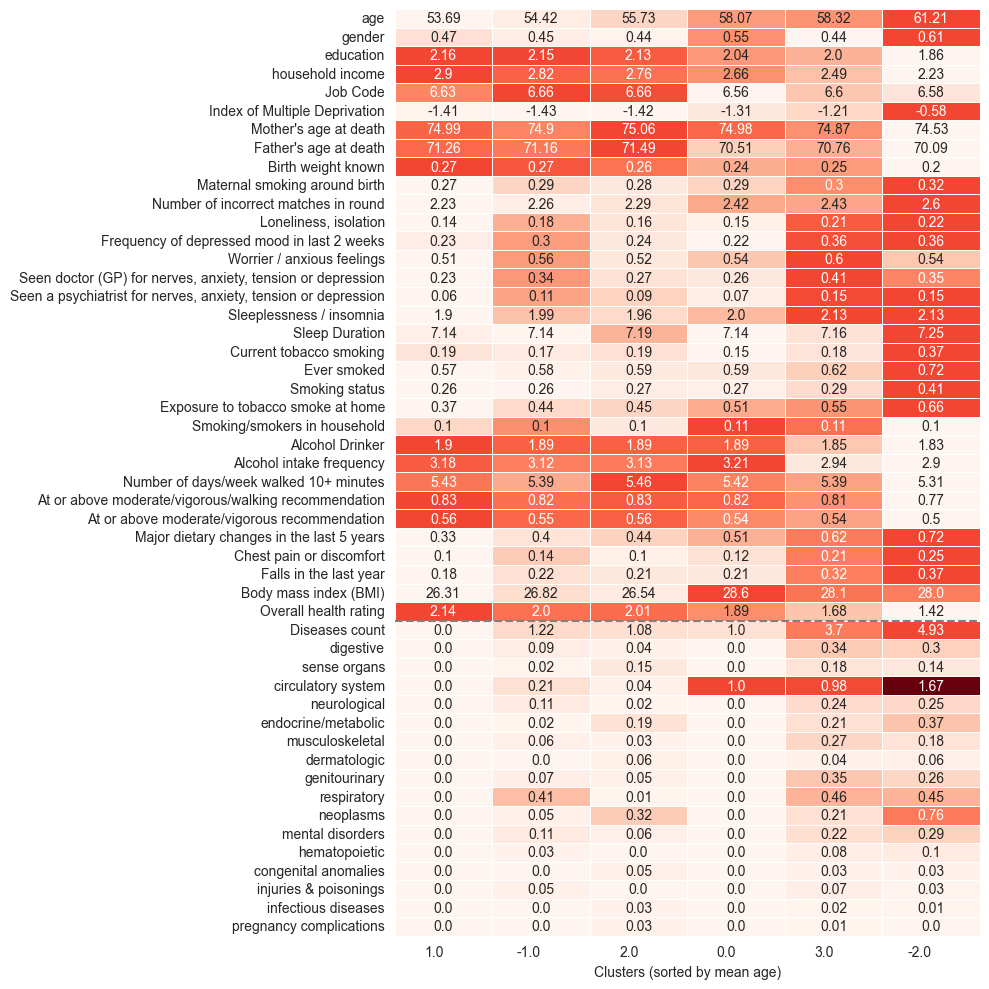

In [94]:

non_replace= [x for x in df.columns if x.startswith('c_')]

plot_cluster_mean_heatmap_with_scaling(df, df_phe_selected, final_data_path, key_vars, non_replace, '21022', params, n_components, n_neighbors, min_dist, min_cluster_size, min_samples)


original codes for 2 histograms (seperate ones)
```
import matplotlib.pyplot as plt
import math

# Ensure the required operations are performed on the DataFrame
if 'diseases_count' in df_embed.columns:
    df_embed.drop(columns=['diseases_count'], inplace=True)
df_embed = df_embed.merge(df[['eid', 'diseases_count']], on='eid')

# Chapter columns
c_cols = [x for x in df.columns if x.startswith('c_')]
missing_cols = [col for col in c_cols if col not in df_embed.columns]
if missing_cols:
    df_embed = df_embed.merge(df[['eid'] + missing_cols], on='eid')

# Get unique clusters and determine the number of subplots needed
unique_clusters = df_embed['cluster'].unique()
num_clusters = len(unique_clusters)

# Determine rows and columns for a 2-row layout for each plot type (4 rows total)
# Double the rows
ncols = 4
nrows = math.ceil(num_clusters / ncols)*2

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows), tight_layout=True)
axes = axes.flatten()  # Flatten to handle indexing easily

# Plot for each cluster
for i, cluster in enumerate(unique_clusters):
    temp = df_embed[df_embed['cluster'] == cluster]
    i = i+4 if i >= 4 else i  # Move to the second row if needed
    
    # Plot histogram for diseases_count
    ax_hist = axes[i]  # First plot for this cluster
    temp['diseases_count'].hist(bins=20, ax=ax_hist)
    ax_hist.set_title(f'Cluster {cluster} Diseases Count\nn={len(temp)}')
    ax_hist.set_xlabel('Diseases Count')
    ax_hist.set_ylabel('Frequency')
    ax_hist.grid(axis='both', linestyle='--', alpha=0.5)
    
    # Plot bar chart for chapter means
    ax_bar = axes[i + 4]  # Second plot for this cluster
    chapter_means = temp[c_cols].mean()
    ax_bar.bar(chapter_means.index, chapter_means.values)
    ax_bar.set_ylim(0, 2.5)
    ax_bar.set_title(f'Cluster {cluster} Chapter Mean Values\nn={len(temp)}')
    ax_bar.set_xlabel('Chapters')
    ax_bar.set_ylabel('Mean Value')
    ax_bar.set_xticks(range(len(chapter_means.index)))
    ax_bar.set_xticklabels([x.replace('c_', '') for x in chapter_means.index], rotation=45)
    ax_bar.grid(axis='both', linestyle='--', alpha=0.5)


fig.suptitle(f'{type}_{year_type}_{n_components}_{n_neighbors}_{min_dist}_{min_cluster_size}_{min_samples}', fontsize=16, y=1.02)
# Display the combined plot
plt.savefig(Path.cwd().parents[1] / f'plot/cluster_disease_info/cluster_diseases_count_chapter_means_{type}_{year_type}_{n_components}_{n_neighbors}_{min_dist}_{min_cluster_size}_{min_samples}.pdf')
plt.show()
```

original codes for radar plot (seperate ones)
```
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# Ensure the required operations are performed on the DataFrame
if 'diseases_count' in df_embed.columns:
    df_embed.drop(columns=['diseases_count'], inplace=True)
df_embed = df_embed.merge(df[['eid', 'diseases_count']], on='eid')

# Chapter columns
c_cols = [x for x in df.columns if x.startswith('c_')]
missing_cols = [col for col in c_cols if col not in df_embed.columns]
if missing_cols:
    df_embed = df_embed.merge(df[['eid'] + missing_cols], on='eid')

# Sort chapter columns alphabetically for consistent order in radar plots

categories = sorted([int(x.replace('c_', '')) for x in c_cols])
c_cols = [f'c_{x}' for x in categories]
# Get unique clusters and determine the number of subplots needed
unique_clusters = df_embed['cluster'].unique()
num_clusters = len(unique_clusters)

# Fixed number of columns and dynamic row calculation for a 4-column layout
ncols = 4
nrows = math.ceil(num_clusters / ncols)

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 4 * nrows), subplot_kw={'polar': True})
axes = axes.flatten()  # Flatten to handle indexing more easily

# Feature labels (for radar chart axes)
num_vars = len(categories)

# Angle setup for the radar plot
angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]  # Close the circle

# Plot for each cluster
for i, cluster in enumerate(unique_clusters):
    temp = df_embed[df_embed['cluster'] == cluster]
    
    # Calculate means for chapter columns, sorted by the reordered c_cols
    chapter_means = temp[c_cols].mean()
    values = chapter_means.values.tolist()
    values += values[:1]  # Close the polygon

    # Plot on the corresponding subplot
    ax = axes[i]
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw one axe per variable
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=8)
    
    # ax.set_yticklabels( fontsize=6)
    
    ax.set_ylim(0, 2.5)
    ax.tick_params(axis='y', labelsize=7) 
    # Add data to radar chart
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f"Cluster {cluster}")
    ax.fill(angles, values, alpha=0.25)
    
    # Set title
    ax.set_title(f"Cluster {cluster} \nn={len(temp)} avg_d = {round(temp['diseases_count'].mean(),3)}", y=1.1, fontsize=9)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
```

In [83]:
df['diseases_count'] = [len(x) if str(x) not in params.nan_str+['0'] else  0 for x in df[selected_cols[0]]]

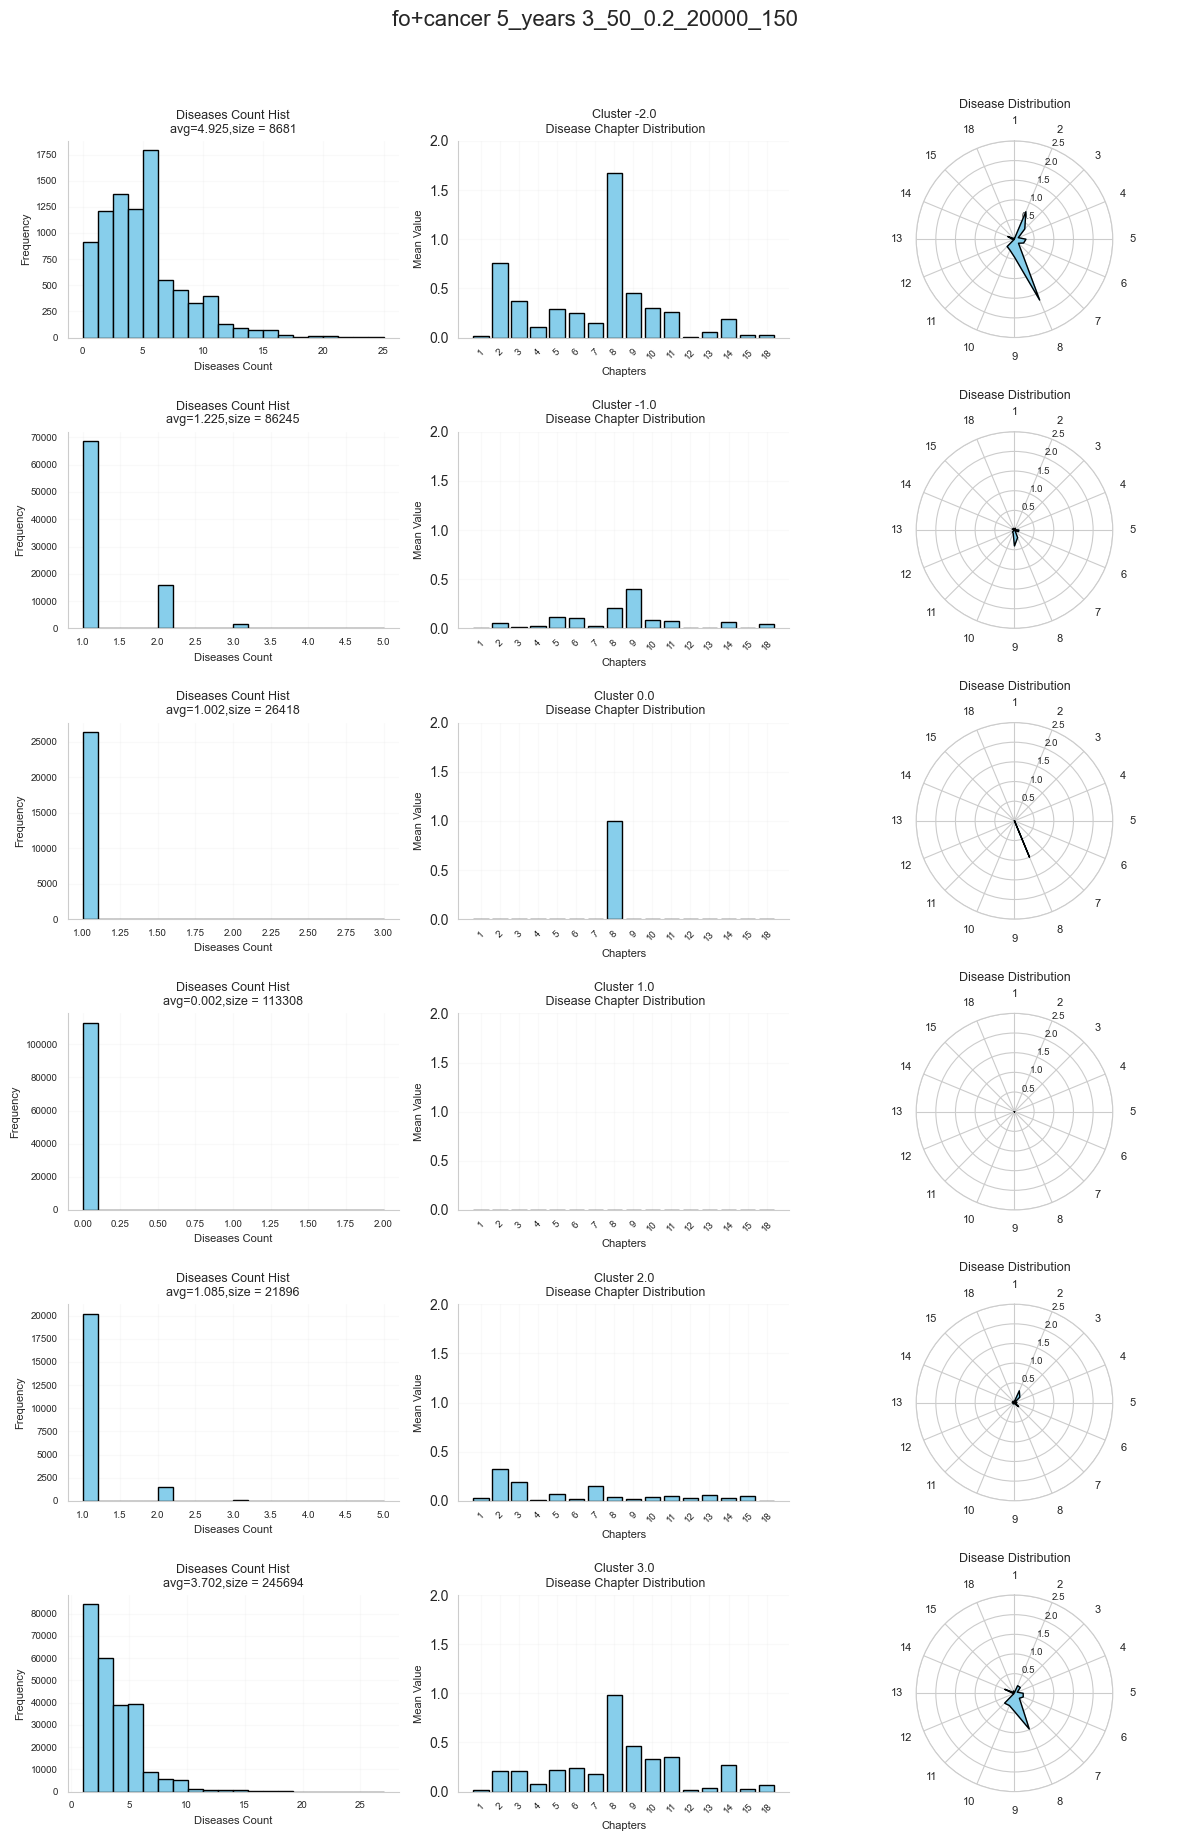

In [95]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math


if 'diseases_count' in df_embed.columns:
    df_embed.drop(columns=['diseases_count'], inplace=True)
df_embed = df_embed.merge(df[['eid', 'diseases_count']], on='eid')

# Chapter columns
c_cols = [x for x in df.columns if x.startswith('c_')]
missing_cols = [col for col in c_cols if col not in df_embed.columns]
if missing_cols:
    df_embed = df_embed.merge(df[['eid'] + missing_cols], on='eid')

# Sort chapter columns alphabetically for consistent order in radar plots
categories = sorted([int(x.replace('c_', '')) for x in c_cols])
c_cols = [f'c_{x}' for x in categories]

# Get unique clusters
unique_clusters = df['cluster'].unique()
num_clusters = len(unique_clusters)

# Layout: 3 subplots per row (histogram, bar plot, radar chart)
ncols = 3
nrows = num_clusters

# Create a figure
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows))

# Feature labels (for radar chart axes)
num_vars = len(categories)
angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]  # Close the circle


unique_clusters.sort()
# Plot for each cluster
for i, cluster in enumerate(unique_clusters):
    temp = df[df['cluster'] == cluster]
    
    # Histogram: Diseases Count (first column)
    ax_hist = axes[i, 0]
    temp['diseases_count'].hist(bins=20, ax=ax_hist, color='skyblue', edgecolor='black')
    ax_hist.set_title(f"  \nDiseases Count Hist\navg={round(temp['diseases_count'].mean(),3)},size = {len(temp)}", fontsize=9)
    ax_hist.set_xlabel('Diseases Count', fontsize=8)
    ax_hist.set_ylabel('Frequency', fontsize=8)
    #ax_hist.set_ylim(0, 120000)
    ax_hist.tick_params(axis='x', labelsize=7)
    ax_hist.tick_params(axis='y', labelsize=7)
    ax_hist.grid(alpha=0.1)
    ax_hist.spines[['right', 'top']].set_visible(False)
    
    # Bar Plot: Chapter Mean Values (second column)
    ax_bar = axes[i, 1]
    chapter_means = temp[c_cols].mean()
    ax_bar.bar(chapter_means.index, chapter_means.values, color='skyblue', edgecolor='black')
    ax_bar.set_ylim(0, 2.0)
    ax_bar.set_title(f"Cluster {cluster}\n Disease Chapter Distribution", fontsize=9)
    ax_bar.set_xlabel('Chapters', fontsize=8)
    ax_bar.set_ylabel('Mean Value', fontsize=8)
    ax_bar.set_xticks(range(len(chapter_means.index)))
    ax_bar.set_xticklabels([x.replace('c_', '') for x in chapter_means.index], rotation=45, fontsize=7)
    ax_bar.grid(alpha=0.1)
    ax_bar.spines[['right', 'top']].set_visible(False)
    
    
    ax_radar_original = axes[i, 2]
    ax_radar_original.grid(False)
    ax_radar_original.axis('off')
    
    
    # Radar Chart: Chapter Mean Values (third column, polar=True)
    ax_radar = fig.add_subplot(nrows, ncols, (i * ncols) + 3, polar=True)
    values = chapter_means.values.tolist()
    # values = [x/sum(chapter_means.values.tolist()) for x in chapter_means.values.tolist()] # in percentage
    values += values[:1]  # Close the polygon
    
    ax_radar.set_theta_offset(np.pi / 2)
    ax_radar.set_theta_direction(-1)
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(categories, fontsize=8)
    ax_radar.set_ylim(0, 2.5)
    ax_radar.tick_params(axis='y', labelsize=7)
    ax_radar.plot(angles, values, linewidth=1,color='black', linestyle='solid', label=f"Cluster {cluster}")
    ax_radar.fill(angles, values, color='skyblue',alpha=1)
    ax_radar.set_title(f"Disease Distribution", fontsize=9)

# Adjust layout and add an overall title
fig.suptitle(f'{type} {year_type} {n_components}_{n_neighbors}_{min_dist}_{min_cluster_size}_{min_samples}', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(Path.cwd().parents[1] / f'plot/cluster_disease_info/cluster_combined_plots_{type}_{year_type}_{n_components}_{n_neighbors}_{min_dist}_{min_cluster_size}_{min_samples}.pdf')
plt.show()

## at disease levels 

In [96]:
#selected_diseases = [401.1, 495.0, 476.0, 296.2, 564.1, 340.0, 411.3, 721.0, 562.1, 411.8, 351.0, 455.0, 716.2, 600.0, 250.2, 835.0, 622.1, 411.2, 280.1, 618.1, 610.8, 274.1, 172.2, 496.21, 475.0, 174.11, 615.0, 365.0, 433.21, 740.1, 569.0, 242.0, 345.0, 362.0, 379.2, 316.0, 555.2, 472.0, 626.8, 54.0, 695.3, 185.0, 642.0, 557.0, 366.2, 596.5, 428.2, 250.1, 353.0, 172.11, 567.0, 626.11, 555.1, 281.12, 256.0, 335.0, 371.1, 303.4, 590.0, 722.9, 296.1, 395.1, 362.7, 585.2, 496.3, 433.2, 300.13, 715.2, 737.3, 395.2, 153.2, 697.0, 448.0, 612.2, 174.1, 433.3, 696.3, 454.0, 474.2, 153.3, 275.0, 342.0, 295.1, 362.4, 182.0, 425.1, 370.0, 332.0, 367.9, 430.1, 383.0, 447.0, 357.0, 379.0, 334.0, 401.22, 251.0, 496.1, 411.9, 695.42, 450.0, 317.11, 649.1, 732.1, 751.12, 755.1, 440.0, 184.11, 300.3,   433.8, 202.2, 189.21, 333.4, 444.0, 609.1, 747.11, 751.21, 344.0, 580.32, 433.1, 165.1, 749.0]

# order by chapter 
selected_diseases = [401.1, 395.1, 433.2, 395.2, 448.0, 433.3, 454.0, 425.1, 411.2, 430.1, 447.0, 401.22, 428.2, 411.9, 455.0, 411.8, 440.0, 411.3, 433.8, 444.0, 433.1, 450.0, 433.21, 751.12, 755.1, 747.11, 751.21, 749.0, 697.0, 696.3, 695.3, 695.42, 569.0, 555.1, 564.1, 567.0, 555.2, 562.1, 557.0, 275.0, 256.0, 250.2, 274.1, 251.0, 250.1, 242.0, 596.5, 612.2, 585.2, 610.8, 580.32, 618.1, 590.0, 600.0, 622.1, 609.1, 626.11, 626.8, 615.0, 281.12, 280.1, 54.0, 835.0, 295.1, 300.3, 317.11, 296.2, 296.1, 300.13, 316.0, 303.4, 737.3, 740.1, 721.0, 732.1, 716.2, 722.9, 715.2, 189.21, 202.2, 184.11, 185.0, 174.11, 172.11, 174.1, 182.0, 172.2, 165.1, 153.2, 153.3, 334.0, 351.0, 333.4, 340.0, 353.0, 345.0, 357.0, 344.0, 335.0, 332.0, 342.0, 642.0, 649.1, 476.0, 496.21, 495.0, 496.3, 475.0, 472.0, 474.2, 496.1, 362.7, 366.2, 379.2, 362.0, 379.0, 362.4, 383.0, 367.9, 370.0, 365.0, 371.1]


categories = {'circulatory system': ['d_401.1', 'd_395.1', 'd_433.2', 'd_395.2', 'd_448.0', 'd_433.3', 'd_454.0', 'd_425.1', 'd_411.2', 'd_430.1', 'd_447.0', 'd_401.22', 'd_428.2', 'd_411.9', 'd_455.0', 'd_411.8', 'd_440.0', 'd_411.3', 'd_433.8', 'd_444.0', 'd_433.1', 'd_450.0', 'd_433.21'], 
              'congenital anomalies': ['d_751.12', 'd_755.1', 'd_747.11', 'd_751.21', 'd_749.0'], 
              'dermatologic': ['d_697.0', 'd_696.3', 'd_695.3', 'd_695.42'], 
              'digestive': ['d_569.0', 'd_555.1', 'd_564.1', 'd_567.0', 'd_555.2', 'd_562.1', 'd_557.0'], 
              'endocrine/metabolic': ['d_275.0', 'd_256.0', 'd_250.2', 'd_274.1', 'd_251.0', 'd_250.1', 'd_242.0'], 
              'genitourinary': ['d_596.5', 'd_612.2', 'd_585.2', 'd_610.8', 'd_580.32', 'd_618.1', 'd_590.0', 'd_600.0', 'd_622.1', 'd_609.1', 'd_626.11', 'd_626.8', 'd_615.0'], 
              'hematopoietic': ['d_281.12', 'd_280.1'], 
              'infectious diseases': ['d_54.0'], 
              'injuries & poisonings': ['d_835.0'], 
              'mental disorders': ['d_295.1', 'd_300.3', 'd_317.11', 'd_296.2', 'd_296.1', 'd_300.13', 'd_316.0', 'd_303.4'], 
              'musculoskeletal': ['d_737.3', 'd_740.1', 'd_721.0', 'd_732.1', 'd_716.2', 'd_722.9', 'd_715.2'], 
              'neoplasms': ['d_189.21', 'd_202.2', 'd_184.11', 'd_185.0', 'd_174.11', 'd_172.11', 'd_174.1', 'd_182.0', 'd_172.2', 'd_165.1', 'd_153.2', 'd_153.3'], 
              'neurological': ['d_334.0', 'd_351.0', 'd_333.4', 'd_340.0', 'd_353.0', 'd_345.0', 'd_357.0', 'd_344.0', 'd_335.0', 'd_332.0', 'd_342.0'], 
              'pregnancy complications': ['d_642.0', 'd_649.1'], 
              'respiratory': ['d_476.0', 'd_496.21', 'd_495.0', 'd_496.3', 'd_475.0', 'd_472.0', 'd_474.2', 'd_496.1'], 
              'sense organs': ['d_362.7', 'd_366.2', 'd_379.2', 'd_362.0', 'd_379.0', 'd_362.4', 'd_383.0', 'd_367.9', 'd_370.0', 'd_365.0', 'd_371.1']}

# diseases names from df

d_cols = [f'd_{x}' for x in selected_diseases]
df_diseases  = df[['eid','cluster']+d_cols].copy()
df_phe_db = pd.read_csv(final_data_path.parents[1]/'Data/intermediate_files/all_icd_phecode.csv')
def get_phecode_description(phecode, df_phe_db):
    phecode = phecode.replace('d_','')
    df_phe_db['phecode'] = df_phe_db['phecode'].astype(str)
    return df_phe_db.loc[df_phe_db['phecode']==str(phecode),'description'].values[0]

#for key in categories.keys():
#    categories[key] = [get_phecode_description(x,df_phe_db) for x in categories[key]]


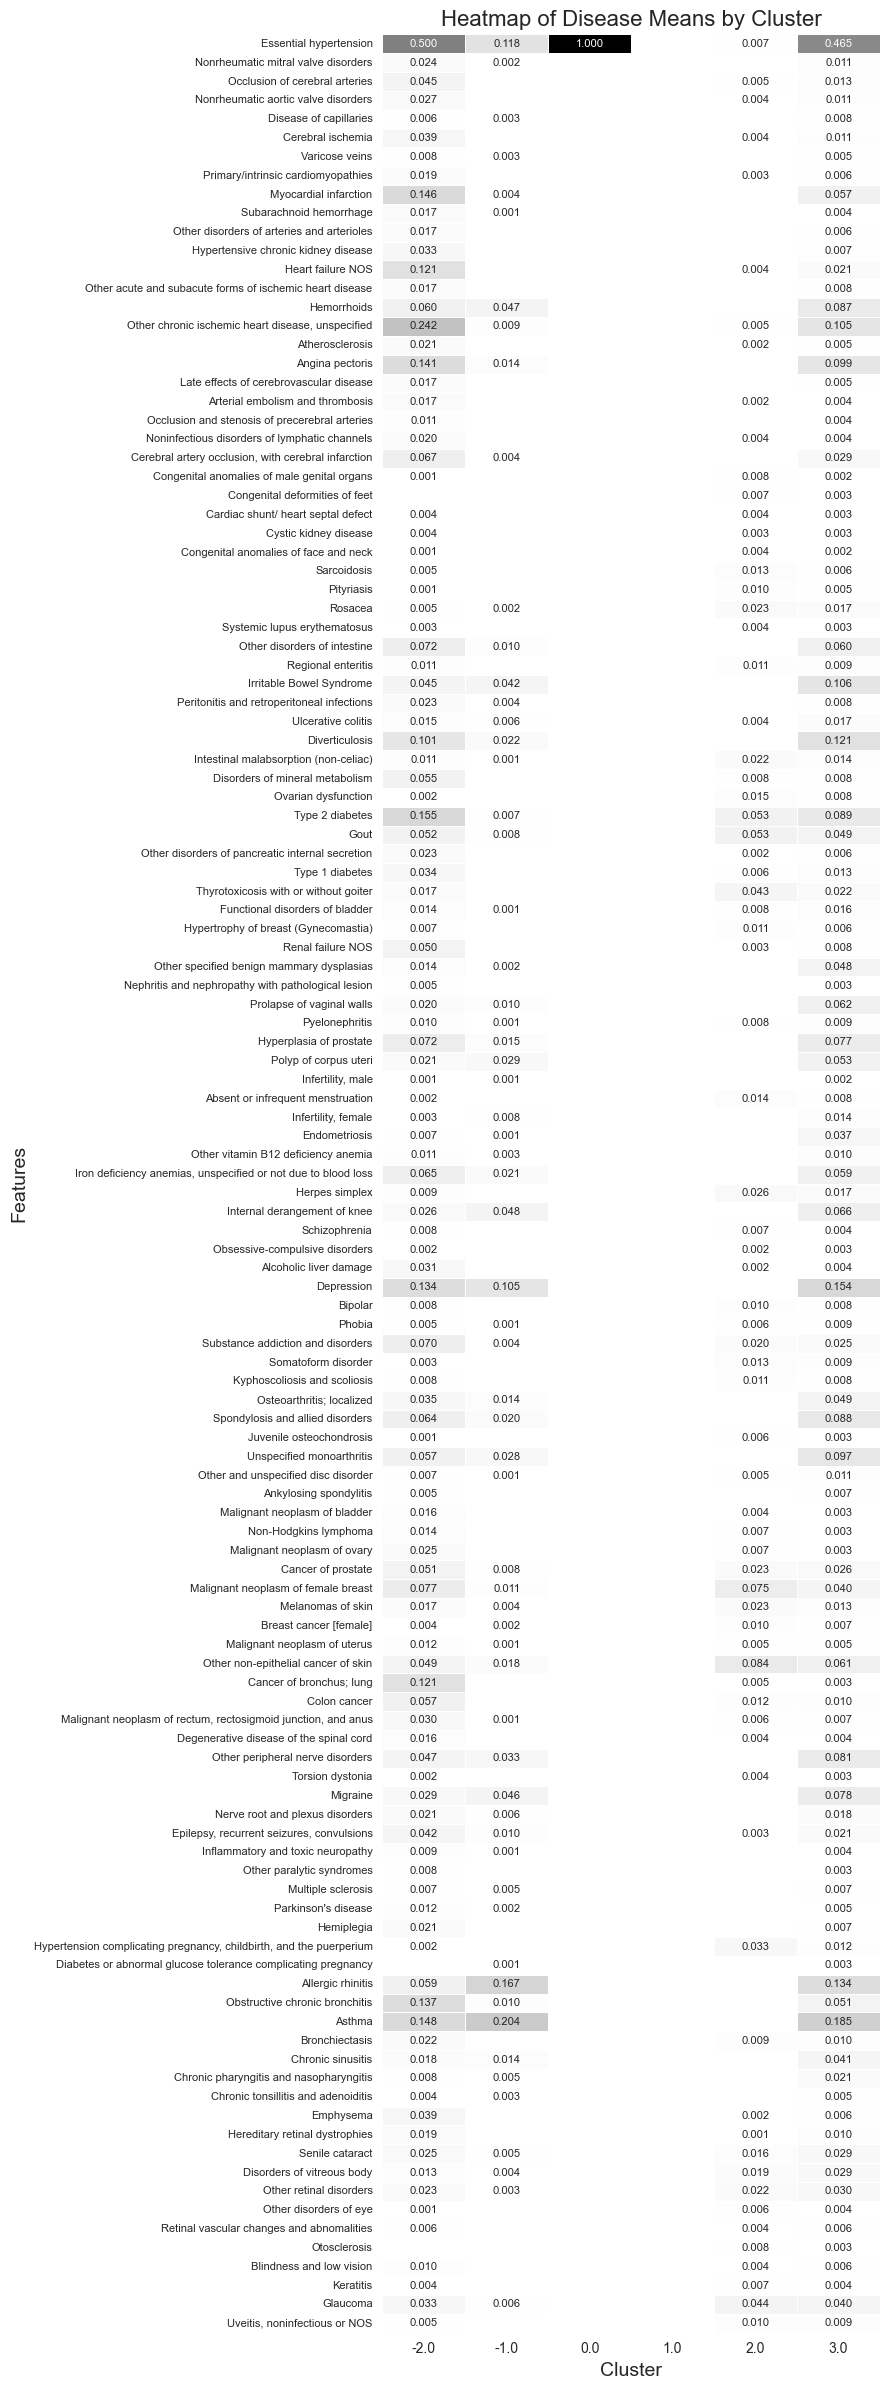

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Group by cluster and calculate mean
cluster_means = df_diseases.groupby('cluster').mean()

# Reorder columns based on the categories
ordered_features = [feature for cat in categories.values() for feature in cat]
cluster_means = cluster_means[ordered_features]
cluster_means.columns = [get_phecode_description(x, df_phe_db) for x in cluster_means.columns]

# Prepare data for annotations
annotations = cluster_means.T.copy()
annotations[annotations <0.0009] = None # Replace 0s with NaN to prevent annotation

# Plot the heatmap
plt.figure(figsize=(9, 24))  # Adjust the figure size as needed
sns.heatmap(
    annotations,
    cmap='gist_gray_r',
    annot=annotations,  # Provide the modified annotations
    cbar=False,  # Discard the color bar
    linewidths=0.5,
    fmt=".3f",  # Format the numbers to two decimal places
    annot_kws={"size": 8}  # Adjust font size for annotations
)

plt.grid(False)
# Set titles and labels
plt.title('Heatmap of Disease Means by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.show()


## disease level: Gender view

In [98]:
df_diseases = df_diseases.merge(df[['eid','31']], on='eid')
df_diseases['gender'] = df_diseases['31'].replace({df_diseases['31'].min():'F',df_diseases['31'].max():'M'})


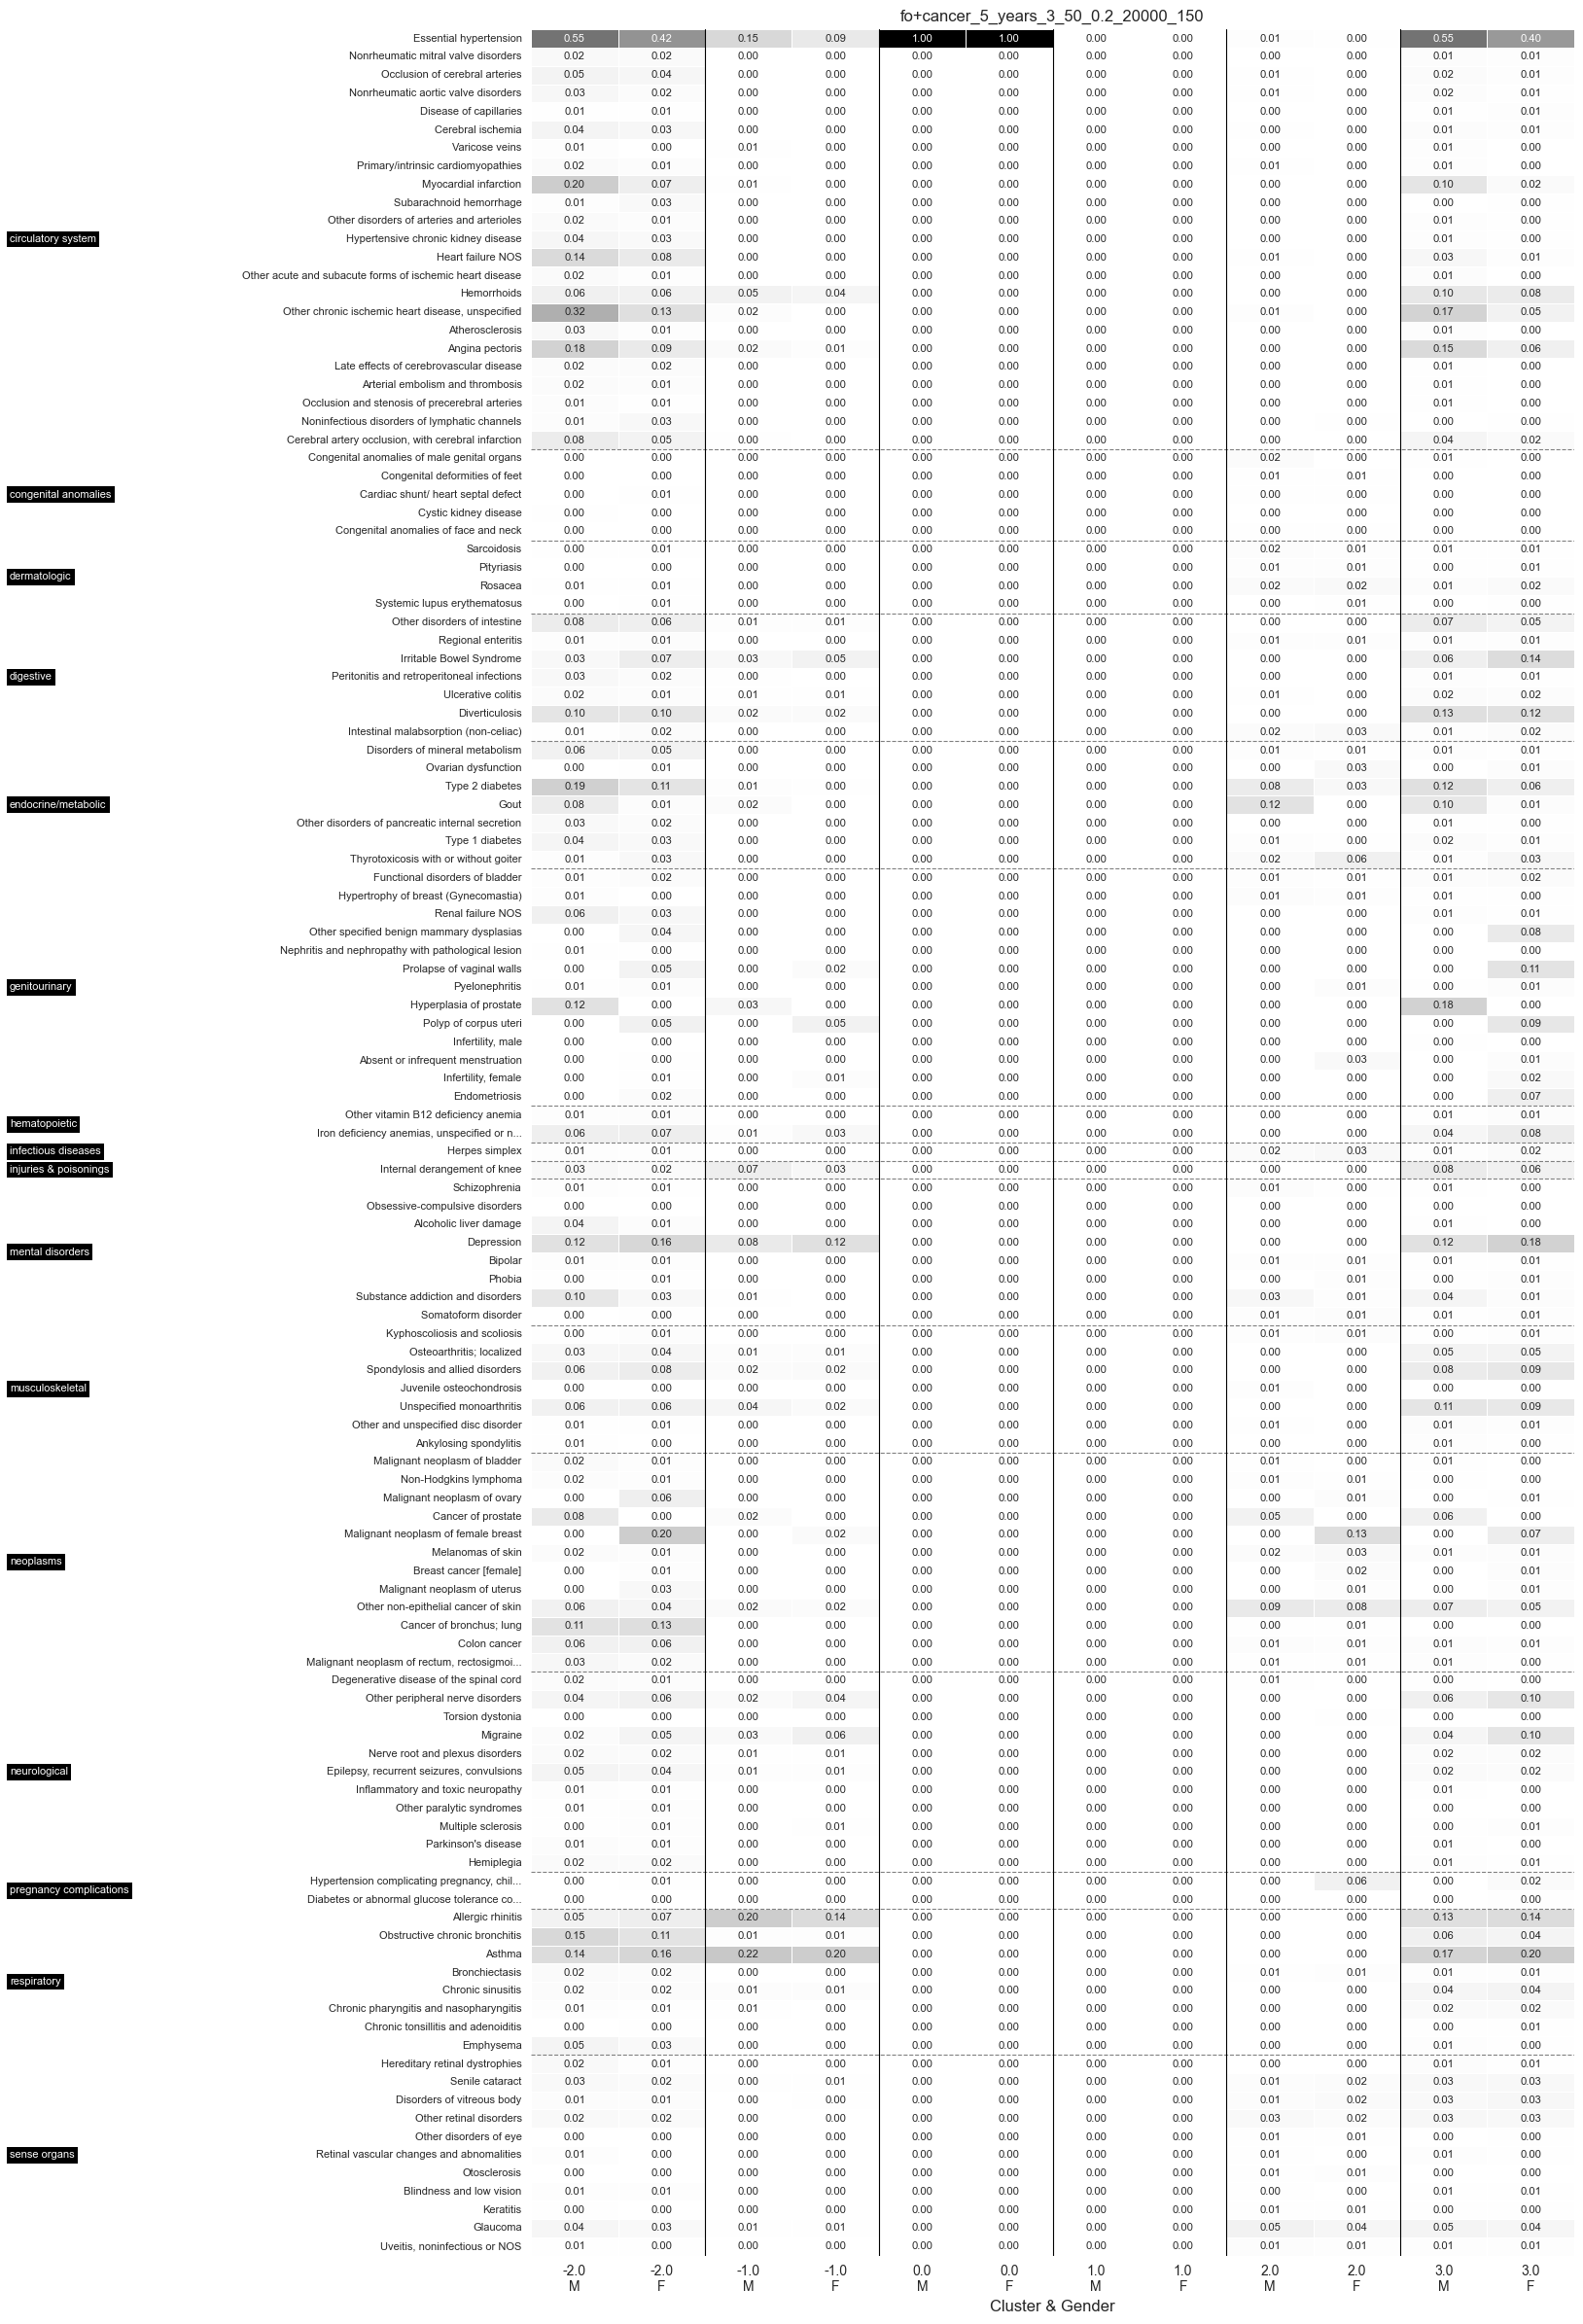

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Group by cluster, gender, and calculate means
gender_means = df_diseases.groupby(['cluster', 'gender']).mean()

# Reorder columns based on the categories
ordered_features = [feature for cat in categories.values() for feature in cat]
gender_means = gender_means[ordered_features]

# Separate male and female proportions
male_proportions = gender_means.loc[(slice(None), 'M'), :].droplevel('gender')
female_proportions = gender_means.loc[(slice(None), 'F'), :].droplevel('gender')

# Combine male and female columns side by side for each cluster
combined_data = pd.DataFrame()
for cluster in male_proportions.index:
    combined_data[f"{cluster}\nM"] = male_proportions.loc[cluster]
    combined_data[f"{cluster}\nF"] = female_proportions.loc[cluster]

# Transpose for heatmap visualization
combined_data = combined_data.T

# Get descriptions for y-axis labels
y_tick_labels = [x if len(x)<=60 else f'{x[0:41]}...'for x in [get_phecode_description(feature, df_phe_db) for feature in ordered_features]]
#x_tick_labels = [x.replace for x in combined_data.index]

# Prepare category boundary positions and category midpoints for annotation
boundary_positions = []
category_midpoints = []
current_position = 0
for category, features in categories.items():
    start = current_position
    current_position += len(features)
    boundary_positions.append(current_position)
    category_midpoints.append((start + current_position) / 2)

# Plot the heatmap
plt.figure(figsize=(18, 24))
ax = sns.heatmap(
    combined_data.T,
    cmap="gist_gray_r",
    annot=True,  # Show values
    fmt=".2f",  # Two decimal places
    linewidths=0.5,
    cbar=False,
    annot_kws={"size": 8}
)

# Add horizontal lines for category boundaries
for boundary in boundary_positions[:-1]:  # Exclude the last position to avoid an extra line
    ax.axhline(boundary, color="gray", linestyle="--", linewidth=0.8)
for i in range(1, len(male_proportions.index)):
    ax.axvline(x=i * 2, color='black', linestyle='-', linewidth=0.8)

# Add category labels to the right-hand side
for midpoint, category in zip(category_midpoints, categories.keys()):
    ax.text(
        -6,  # Position to the right of the heatmap
        midpoint,
        category,
        va="center",
        ha="left",
        fontsize=8,
        color="white",
        bbox=dict(facecolor="black", edgecolor="none", boxstyle="square")
    )


# Update y-axis tick labels
ax.set_yticklabels(y_tick_labels, fontsize=8)

# Set titles and labels
plt.title(f"{type}_{year_type}_{n_components}_{n_neighbors}_{min_dist}_{min_cluster_size}_{min_samples}", fontsize=12)
plt.xlabel("Cluster & Gender", fontsize=12)
#plt.ylabel("Features", fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig(Path.cwd().parents[1] / f'plot/cluster_disease_info/disease_level_plot_by_gender_{type}_{year_type}_{n_components}_{n_neighbors}_{min_dist}_{min_cluster_size}_{min_samples}.pdf')
plt.show()


In [101]:
len([x for x in df.columns if x.startswith('d_')])

316

In [ ]:
# Chapter columns
c_cols = [x for x in df.columns if x.startswith('c_')]
missing_cols = [col for col in c_cols if col not in df_embed.columns]
if missing_cols:
    df_embed = df_embed.merge(df[['eid'] + missing_cols], on='eid')


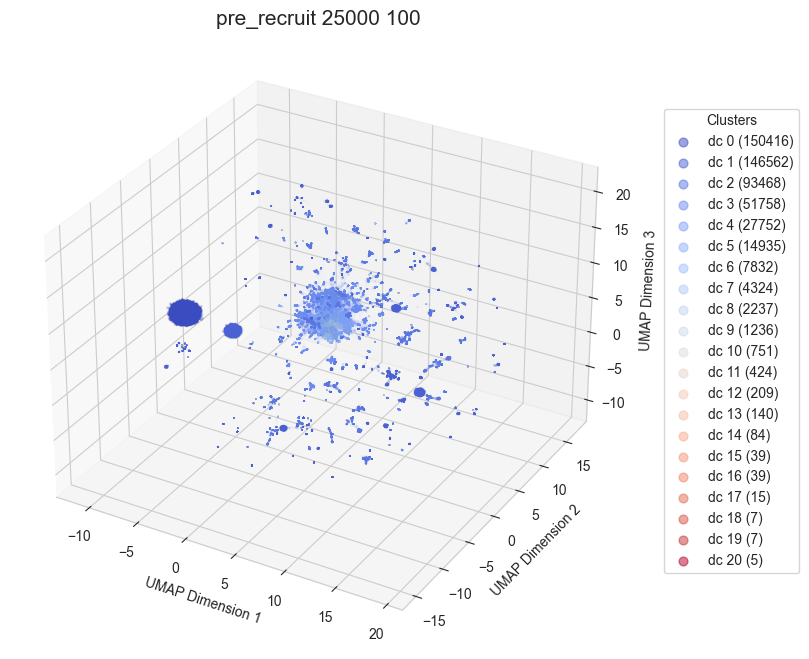

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

df_embed = temp.copy()

# Assuming `df_embed` and other variables are already defined
df_embed.rename(columns={'diseases_count': 'old_disease_count'}, inplace=True)
df_embed = df_embed.merge(df[['eid', 'diseases_count']], on='eid')
df_embed= df_embed.loc[df_embed['diseases_count']<=20]
labels = df_embed['diseases_count']

if n_components == 2:
    plt.scatter(df_embed[0], df_embed[1], c=labels, cmap='coolwarm', s=0.001, alpha=1)
    plt.colorbar(label='Cluster')
    plt.title(f'UMAP + HDBSCAN Clustering {year_type}', fontsize=15)
    plt.show()
elif n_components == 3:
    unique_labels = np.unique(labels)  # Get unique labels

    # Define colors for each label using the coolwarm colormap
    cmap = plt.cm.coolwarm
    norm = plt.Normalize(vmin=min(unique_labels), vmax=max(unique_labels))
    colors = [cmap(norm(label)) for label in unique_labels]

    # Create a scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each cluster with its unique color
    for label, color in zip(unique_labels, colors):
        mask = labels == label
        ax.scatter(df_embed[0][mask], df_embed[1][mask], df_embed[2][mask],
                   c=[color], label=f'dc {label} ({len(df_embed[mask])})', s=0.001, alpha=0.5)

    # Adjust the legend
    legend = ax.legend(
        title="Clusters",
        loc='center left',  # Position legend on the right-hand side
        bbox_to_anchor=(1.05, 0.5),  # Offset to the right
        fontsize=10,
        markerscale=200  # Increase marker size in the legend
    )
    
    # Set plot titles and labels
    ax.set_title(f'{year_type} {min_cluster_size} {min_samples}', fontsize=15)
    ax.set_xlabel('UMAP Dimension 1')
    ax.set_ylabel('UMAP Dimension 2')
    ax.set_zlabel('UMAP Dimension 3')
    ax.grid(True, alpha=0)

    plt.show()
